In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib     
import time
import scipy.signal as signal
import os
import seaborn as sns
import latex

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [32]:
main_path = r"Programowanie_Roff_wyniki\Programowanie_Roff_wyniki_AmpOff=-1_dtOff=0.01_memNumber1.csv"
data = pd.read_csv(main_path)
data

,Timestamp,No. pulses,No. Test,R,Succes,dt_Ron,Amp_RonR,q,E_memristor,State
0,1.676903e+09,0,0,1.270443,False,0.01,-1.0,0.026119,0.007096,R_on
1,1.676903e+09,1,0,3.222214,False,0.01,-1.0,-0.001490,0.000428,R_on
2,1.676903e+09,2,0,25.094993,False,0.01,-1.0,-0.000974,0.000505,Unknown
3,1.676903e+09,3,0,27.082785,False,0.01,-1.0,-0.000754,0.000484,Unknown
4,1.676903e+09,4,0,38.737542,False,0.01,-1.0,-0.000662,0.000452,Unknown
...,...,...,...,...,...,...,...,...,...,...
385,1.676904e+09,3,99,56.658751,True,0.10,1.5,-0.000368,0.000304,R_off
386,1.676904e+09,0,100,2.517745,False,0.01,-1.0,0.024057,0.008828,R_on
387,1.676904e+09,1,100,32.562416,False,0.01,-1.0,-0.000976,0.000438,Unknown
388,1.676904e+09,2,100,46.743441,False,0.01,-1.0,-0.000408,0.000329,Unknown


In [33]:
data.columns = ["Time", "Pulses", "Tests",'R','isSucces','dt_Ron',
       'Amp_Ron', 'q', 'E_memristor', 'State']

In [34]:
data.columns

Index(['Time', 'Pulses', 'Tests', 'R', 'isSucces', 'dt_Ron', 'Amp_Ron', 'q',
       'E_memristor', 'State'],
      dtype='object')

In [35]:
data.head()

,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State
0,1.676903e+09,0,0,1.270443,False,0.01,-1.0,0.026119,0.007096,R_on
1,1.676903e+09,1,0,3.222214,False,0.01,-1.0,-0.001490,0.000428,R_on
2,1.676903e+09,2,0,25.094993,False,0.01,-1.0,-0.000974,0.000505,Unknown
3,1.676903e+09,3,0,27.082785,False,0.01,-1.0,-0.000754,0.000484,Unknown
4,1.676903e+09,4,0,38.737542,False,0.01,-1.0,-0.000662,0.000452,Unknown


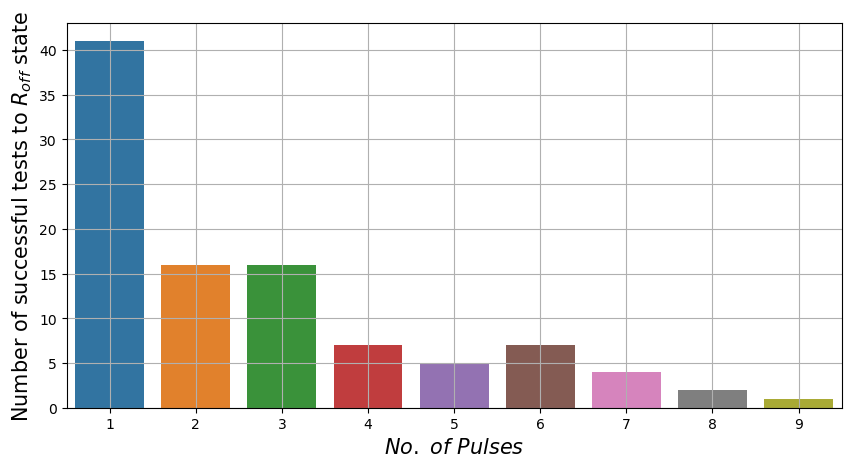

In [74]:
temp_data = data[data["isSucces"]==True].groupby(by="Pulses").count()
plt.figure(figsize=(10,5))
sns.barplot( x=temp_data.index, y="R", data=temp_data)
plt.xlabel("$No.\ of\ Pulses$", fontsize=15)
plt.ylabel("Number of successful tests to $R_{off}$ state ", fontsize=15)
plt.grid(True)
plt.show()


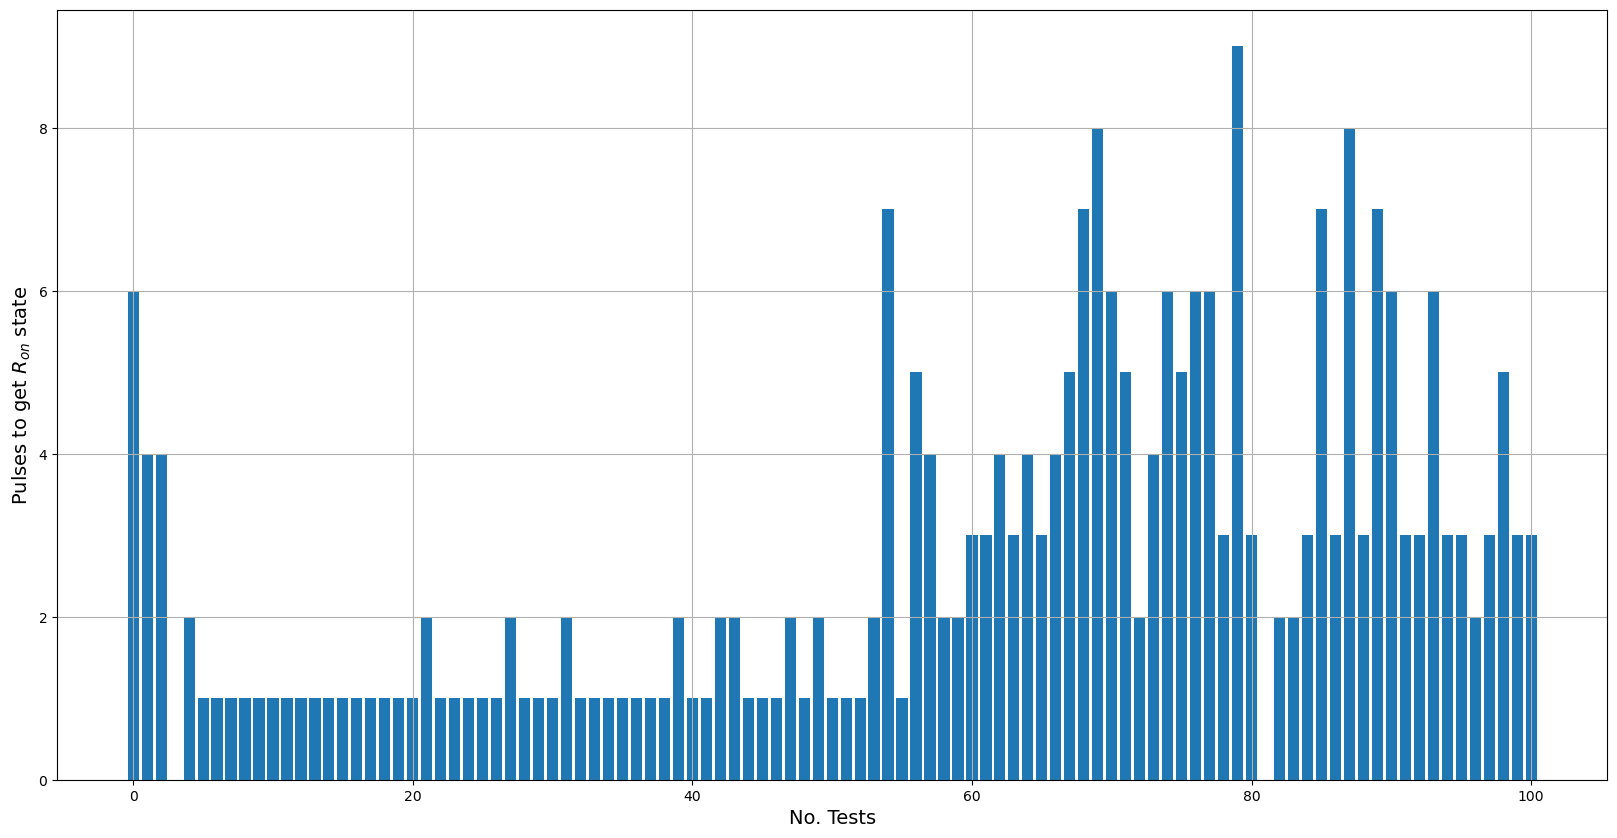

In [37]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Pulses"],width=0.8)
plt.xlabel("No. Tests",fontdict={'fontsize':14})
plt.ylabel("Pulses to get $R_{on}$ state",fontdict={'fontsize':14})
plt.grid(True)




In [38]:
data['Q_integrated'] = np.nan
data['E_integrated'] = np.nan



for i in data.index:
    if data.loc[i,"Pulses"] == 0:
        data.loc[i,"Q_integrated"] = 0
    else:
        data.loc[i,"Q_integrated"] = data.loc[i-1,"Q_integrated"]+data.loc[i,"q"]
    if data.loc[i,"Pulses"] == 0:
        data.loc[i,"E_integrated"] = 0
    else:
        data.loc[i,"E_integrated"] = data.loc[i-1,"E_integrated"]+data.loc[i,"E_memristor"]

data['Q_integrated']





0      0.000000
1     -0.001490
2     -0.002464
3     -0.003218
4     -0.003880
         ...   
385   -0.001512
386    0.000000
387   -0.000976
388   -0.001385
389   -0.001783
Name: Q_integrated, Length: 390, dtype: float64

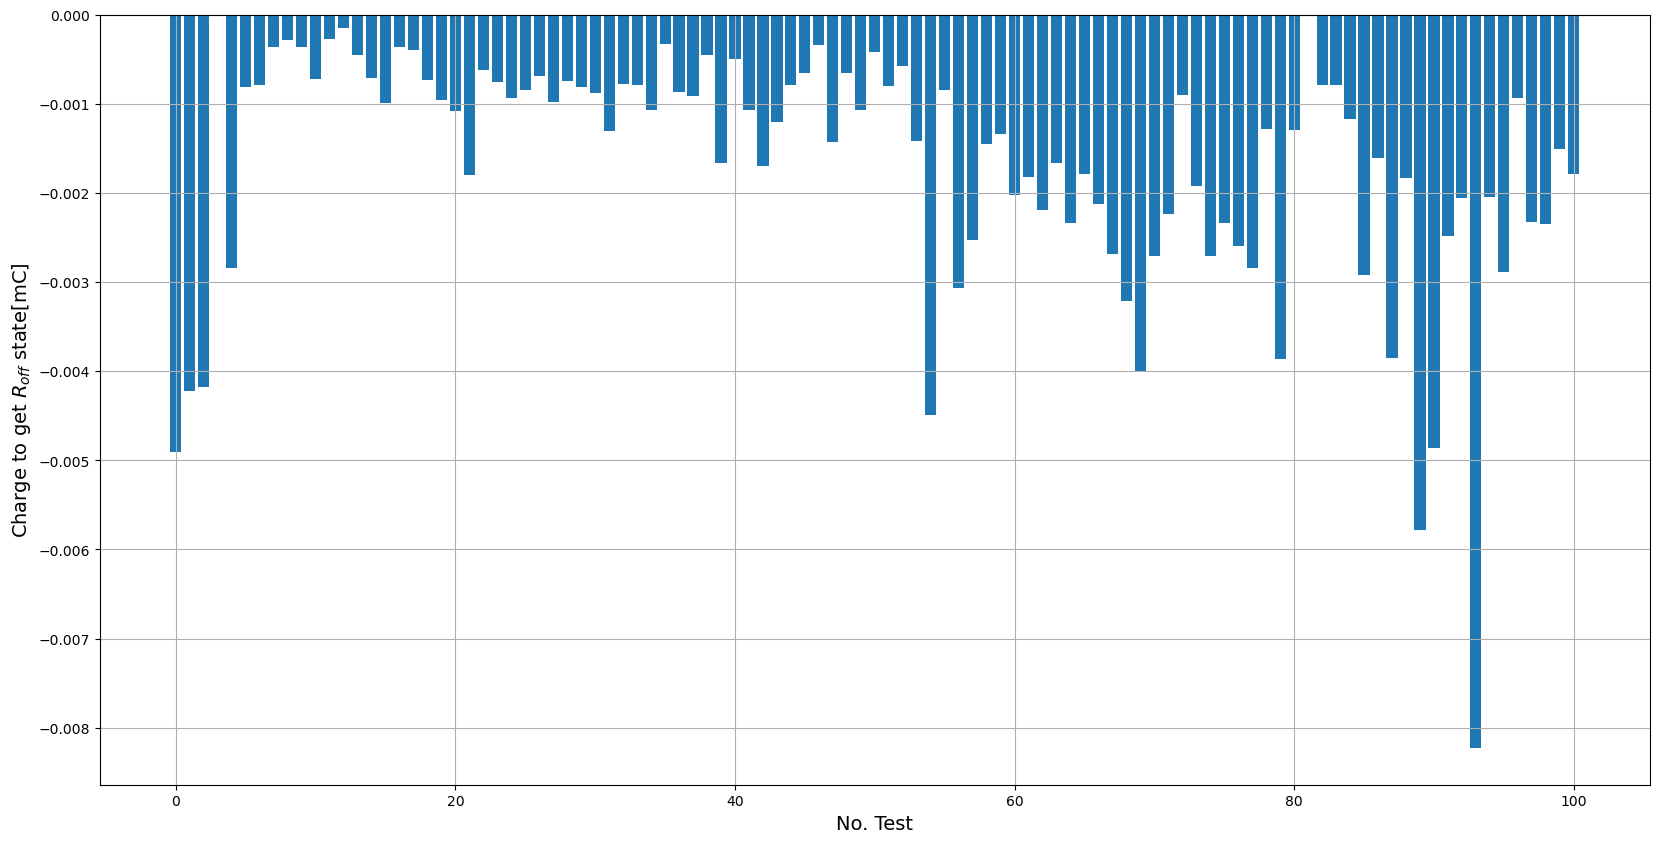

In [40]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Q_integrated"],width=0.8)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Charge to get $R_{off}$ state[mC]",fontdict={'fontsize':14})
plt.grid(True)



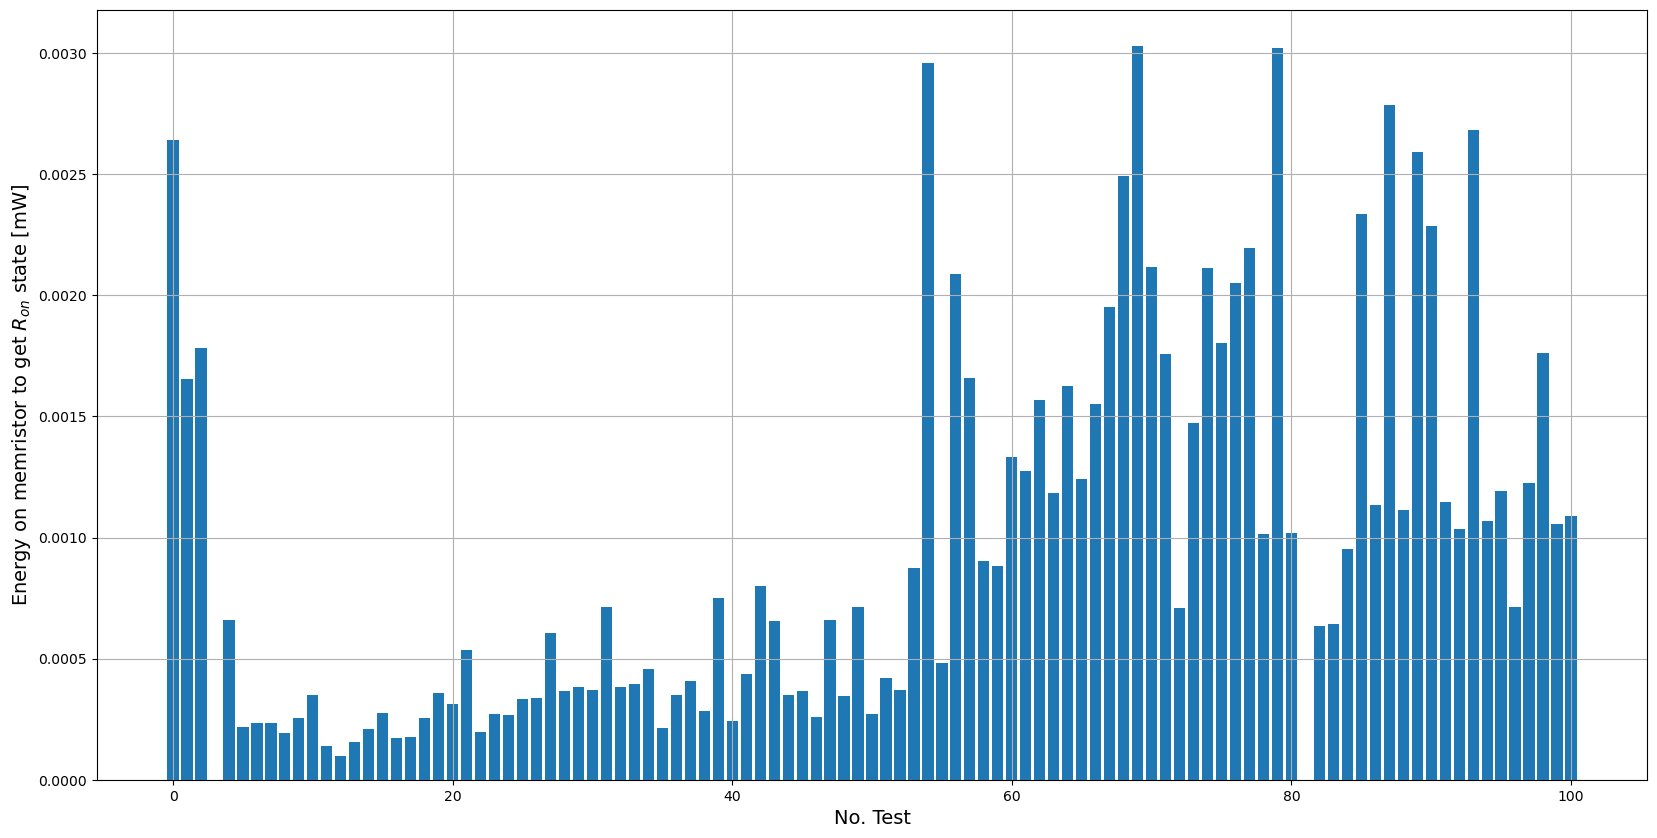

In [41]:

temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["E_integrated"],width=0.8,)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Energy on memristor to get $R_{on}$ state [mW]",fontdict={'fontsize':14})
plt.grid(True)


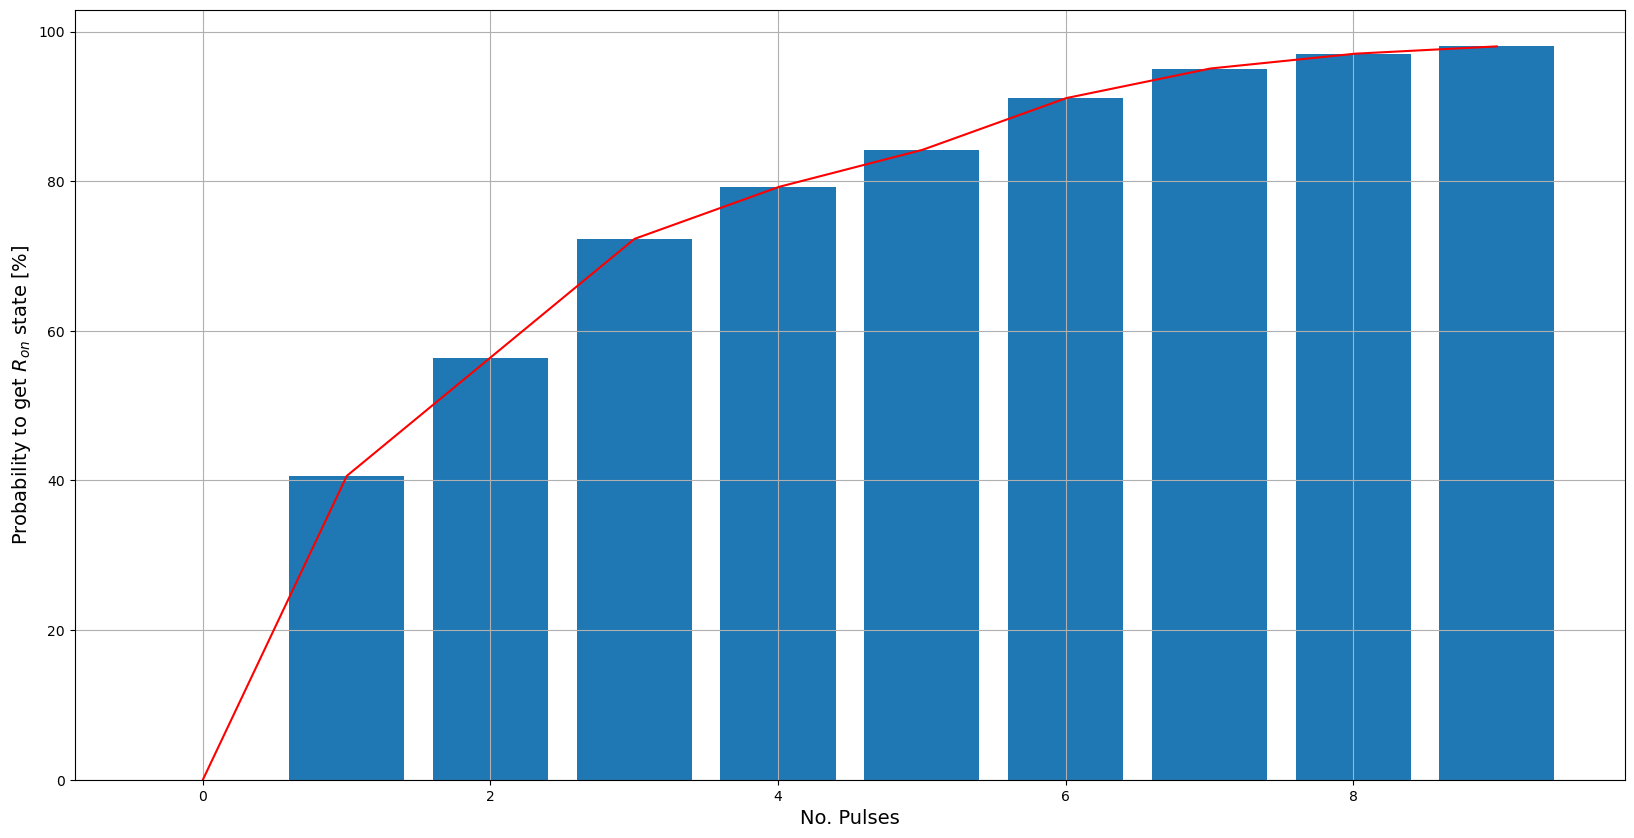

In [44]:
from scipy.interpolate import interp1d

number_of_tests = len(data["Tests"].unique())

temp_data = data[data["isSucces"]==True].groupby(by="Pulses",as_index=False).count()
temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
temp_data.reset_index(inplace=True)
P = 0
for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P
x = temp_data['Pulses'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.bar(x=x, height=y,width=0.8)
plt.xlabel("No. Pulses",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{on}$ state [%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y)
plt.plot(x_i, cs(x_i),'r') 
#bla bla


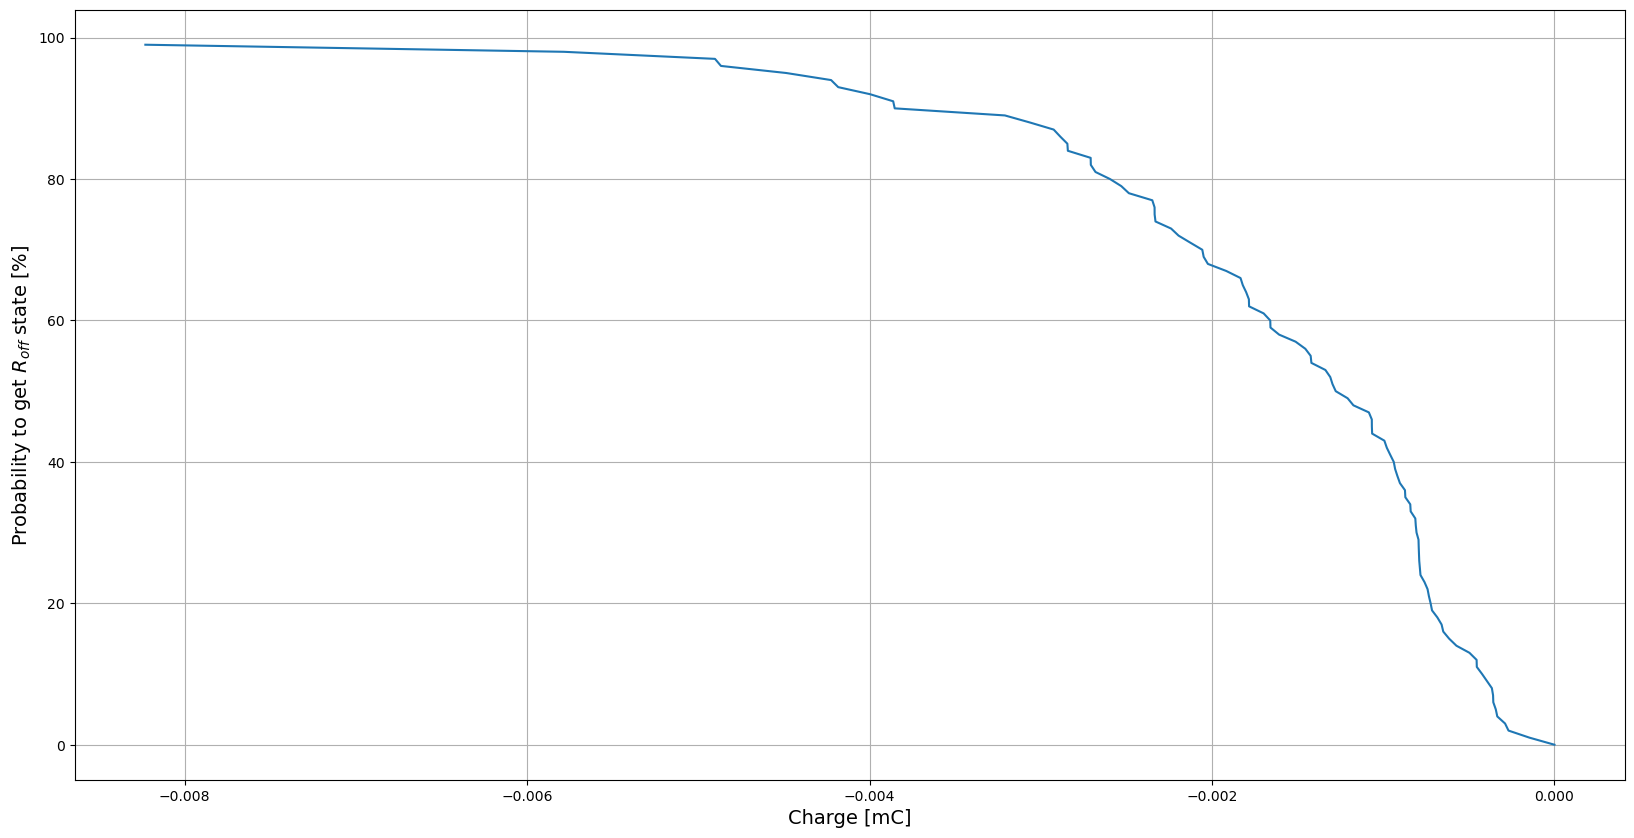

In [46]:

number_of_tests = np.max(data["Tests"])

temp_data = data[data["isSucces"]==True].groupby(by="Q_integrated",as_index=False).count()
temp_data.sort_values(by="Q_integrated",ascending=False,inplace=True)
temp_data.reset_index(drop=True,inplace=True)
temp_data

temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
P = 0

for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P

x = temp_data['Q_integrated'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.xlabel("Charge [mC]",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{off}$ state [%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y,kind='previous')


t = data["R"] == "nan"
t = np.where(t==True)
data.iloc[t[0]]
data =data.drop(labels = t[0],axis=0).reset_index(drop=True)
data["R"] = data["R"].astype(np.float64)



#plt.plot(x_i, cs(x_i),'r')




In [47]:
data

,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State,Q_integrated,E_integrated
0,1.676903e+09,0,0,1.270443,False,0.01,-1.0,0.026119,0.007096,R_on,0.000000,0.000000
1,1.676903e+09,1,0,3.222214,False,0.01,-1.0,-0.001490,0.000428,R_on,-0.001490,0.000428
2,1.676903e+09,2,0,25.094993,False,0.01,-1.0,-0.000974,0.000505,Unknown,-0.002464,0.000933
3,1.676903e+09,3,0,27.082785,False,0.01,-1.0,-0.000754,0.000484,Unknown,-0.003218,0.001417
4,1.676903e+09,4,0,38.737542,False,0.01,-1.0,-0.000662,0.000452,Unknown,-0.003880,0.001869
...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.676904e+09,3,99,56.658751,True,0.10,1.5,-0.000368,0.000304,R_off,-0.001512,0.001056
386,1.676904e+09,0,100,2.517745,False,0.01,-1.0,0.024057,0.008828,R_on,0.000000,0.000000
387,1.676904e+09,1,100,32.562416,False,0.01,-1.0,-0.000976,0.000438,Unknown,-0.000976,0.000438
388,1.676904e+09,2,100,46.743441,False,0.01,-1.0,-0.000408,0.000329,Unknown,-0.001385,0.000767


In [75]:
temp_data = data[data['State'] == "Unknown"]


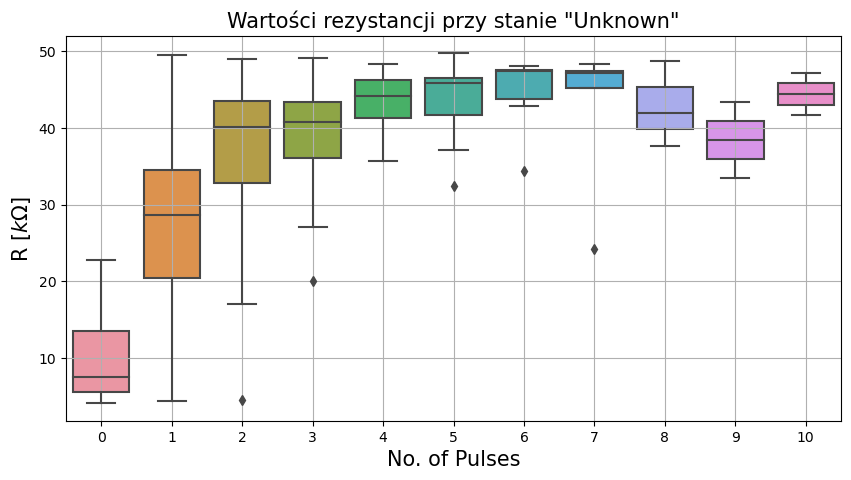

In [76]:
plt.figure(figsize=(10,5))
sns.boxplot(data=temp_data, x="Pulses",y="R")
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("R $[k\Omega]$ ", fontsize=15)
plt.grid(True)
plt.title('Wartości rezystancji przy stanie "Unknown"', fontsize = 15)
plt.show()



In [51]:
temp_data = data[data['Pulses'] != 0]

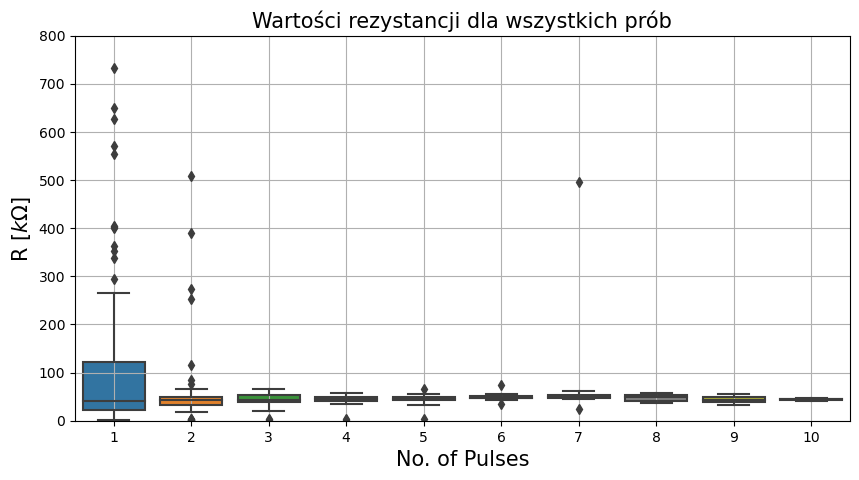

In [58]:


plt.figure(figsize=(10,5))
sns.boxplot(data=temp_data, x="Pulses",y="R")
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)
plt.ylim((0,800))
plt.ylabel("R $[k\Omega]$ ", fontsize=15)
plt.title("Wartości rezystancji dla wszystkich prób", fontsize=15)
plt.show()
#plt.savefig('histogram.pgf')

In [71]:
k = np.logical_and( temp_data["Pulses"]>=3, temp_data["R"]>=100 )
k = np.where(k==True)
ind = temp_data.iloc[k[0]].index
temp_data =temp_data.drop(index=ind,axis=0).reset_index(drop=True)
#temp_data.max()


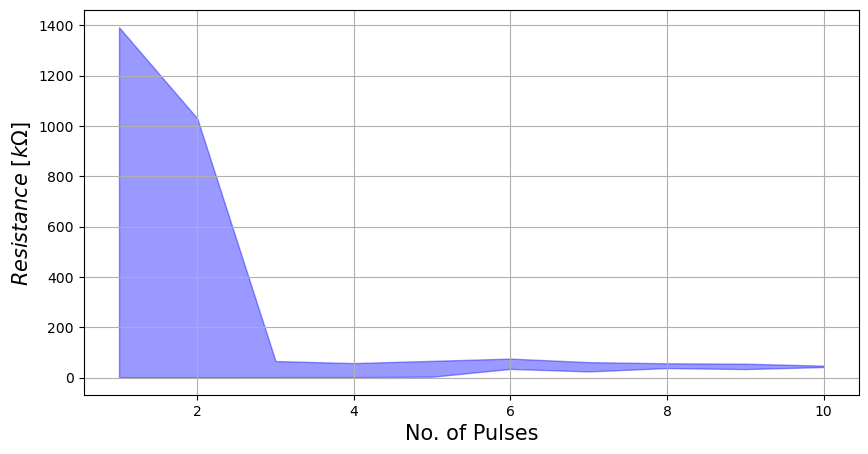

In [72]:
plt.figure(figsize=(10,5))
max = temp_data.groupby('Pulses').max()["R"]
min = temp_data.groupby('Pulses').min()["R"]
plt.fill_between(max.index, max, min, alpha=0.4, color='blue')
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("$Resistance\ [k\Omega]$ ", fontsize=15)
plt.grid(True)
#plt.ylim((0,25))

In [73]:
data[data['State']=="R_off"].min()

Time            1676902787.361067
Pulses                          1
Tests                           0
R                       50.120353
isSucces                     True
dt_Ron                        0.1
Amp_Ron                       1.5
q                       -0.001172
E_memristor              0.000098
State                       R_off
Q_integrated            -0.008229
E_integrated             0.000098
dtype: object